<a href="https://colab.research.google.com/github/gkdivya/CNN/blob/master/AdvConvolutionsInDetail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook, advanced convolutions are explored

## We will redesign the CIFAR10 network designed in previous example using different convolutions in the below order:

1.   Normal Convolution
2.   Spatially Separable Convolution  (Conv2d(x, (3,1)) followed by Conv2D(x,(1,3))
3.   Depthwise Separable Convolution
4.   Grouped Convolution (use 3x3, 5x5 only)
5.   Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2) 

and train it for 50 epochs







### Importing libraries 

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 

from keras.layers import Input
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.merge import concatenate
from keras.layers import MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.utils import np_utils

Using TensorFlow backend.


### Loading CIFAR10 dataset 

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


**Visualiaze some sample Images from the dataset**

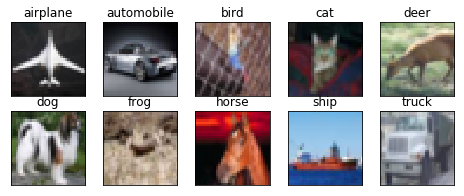

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

**Dividing pixel values by 255, standardize the inputs, also performed one hot encoding**

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

**Defining functions to plot model history, find accuracy**

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def accuracy_iterator(test_iterator, model):
  _, accuracy = model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)
  return (accuracy * 100)

### Define Model using functional api

In [0]:
inputs = Input(shape=(32,32,3), name='ImageInput')
x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(inputs) #3
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x) #5
x = MaxPooling2D((2,2), name='pool1')(x) #10
x = Convolution2D(64,(1,1),activation='relu', name='Conv1x1_1')(x)

W0826 06:10:39.455827 140247121037184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 06:10:39.499428 140247121037184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 06:10:39.528154 140247121037184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 06:10:39.545437 140247121037184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0826 06:10:39.546488 1402471210

Spatially Seperable Convolution

![alt text](https://github.com/gkdivya/EVA/blob/master/Advanced%20Convolutions/assets/SpatialSeperableConvolution.png?raw=true)

In [0]:
x = SeparableConv2D(64, (3,1), activation='relu', padding='same', name='Conv3_1')(x)
x = SeparableConv2D(64, (1,3), activation='relu', padding='same', name='Conv3_2')(x) #12
x = BatchNormalization()(x)
x = SeparableConv2D(128, (3,1), activation='relu', depth_multiplier=4, padding='same', name='Conv4_1')(x)
x = SeparableConv2D(128, (1,3), activation='relu', depth_multiplier=4, padding='same', name='Conv4_2')(x) #14
x = BatchNormalization()(x)
x = MaxPooling2D((2,2), name='pool2')(x) #28
x = Convolution2D(64,(1,1),activation='relu')(x)

In [0]:
x2 = Convolution2D(32, (3, 3),activation='relu', padding='same', name='Conv5_1')(x) #
x2 = BatchNormalization()(x2)

x3 = Convolution2D(32, (5, 5),activation='relu', padding='same', name='Conv5_2')(x) #
x3 = BatchNormalization()(x3)

x = concatenate ([x2,x3]) # grouped convolution of 3x3 5x5 #15x15x64

In [0]:
x4 = Convolution2D(32, (3, 3), dilation_rate=1, activation='relu', padding='same', name='Conv6_1')(x) #
x4 = BatchNormalization()(x4)

x5 = Convolution2D(32, (5, 5), dilation_rate=2, activation='relu', padding='same', name='Conv6_2')(x) #
x5 = BatchNormalization()(x5)

x = concatenate ([x4,x5]) # grouped convolution of 3x3 5x5 #15x15x64

In [0]:
x = Convolution2D(32, (8, 8), dilation_rate=1, activation='relu', name='Conv7_1')(x)
x = Convolution2D(10, (1, 1))(x)

In [0]:
flat = Flatten()(x)
predictions = Activation('softmax')(flat)
model = Model(inputs=inputs, outputs=predictions)

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageInput (InputLayer)         (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Conv1_1 (Conv2D)                (None, 32, 32, 64)   1792        ImageInput[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         Conv1_1[0][0]                    
__________________________________________________________________________________________________
Conv2_1 (Conv2D)                (None, 32, 32, 128)  73856       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
pool1 (Max

In [0]:
# checkpoint
filepath="/content/drive/My Drive/AdvancedConvolutions/Assignment6B/Models/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# define early stopping callback
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')

In [0]:
callbacks_list = [earlystop, checkpoint]

Epoch 1/100
98/98 [==============================] - 43s 439ms/step - loss: 1.9211 - acc: 0.3683 - val_loss: 1.5081 - val_acc: 0.4580

Epoch 00001: val_acc improved from 0.09640 to 0.45800, saving model to /content/drive/My Drive/AdvancedConvolutions/Assignment6B/Models/weights-01-0.46.hdf5
Epoch 2/100
98/98 [==============================] - 41s 414ms/step - loss: 1.2158 - acc: 0.5668 - val_loss: 1.3506 - val_acc: 0.5414

Epoch 00002: val_acc improved from 0.45800 to 0.54140, saving model to /content/drive/My Drive/AdvancedConvolutions/Assignment6B/Models/weights-02-0.54.hdf5
Epoch 3/100
98/98 [==============================] - 41s 415ms/step - loss: 0.9211 - acc: 0.6743 - val_loss: 1.2698 - val_acc: 0.5773

Epoch 00003: val_acc improved from 0.54140 to 0.57730, saving model to /content/drive/My Drive/AdvancedConvolutions/Assignment6B/Models/weights-03-0.58.hdf5
Epoch 4/100
98/98 [==============================] - 41s 416ms/step - loss: 0.7302 - acc: 0.7433 - val_loss: 0.9703 - val_ac

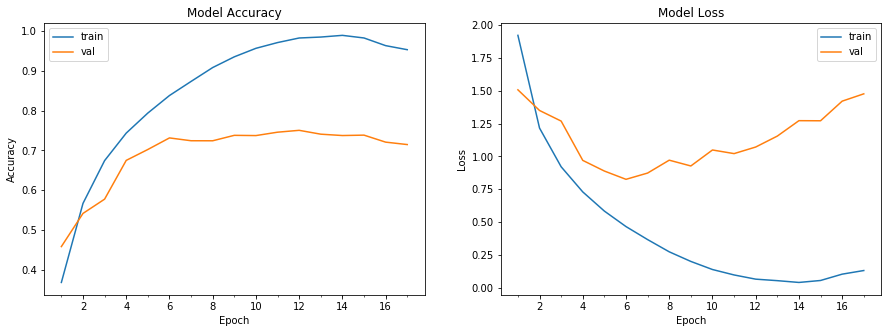

Accuracy on test data is: 71.46


In [0]:
from keras.preprocessing.image import ImageDataGenerator

# applying transformation to image
train_gen = ImageDataGenerator(zoom_range=0.0, horizontal_flip=False, featurewise_center=True, featurewise_std_normalization=True)
test_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit the data augmentation
train_gen.fit(train_features)
test_gen.fit(test_features)

training_generator= train_gen.flow(train_features, train_labels, batch_size=512)
testing_generator= test_gen.flow(test_features, test_labels, batch_size=512, shuffle=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(training_generator, 
                    steps_per_epoch = len(training_generator),
                    epochs=100,
                    validation_data = testing_generator,
                    validation_steps = len(testing_generator),
                    callbacks = callbacks_list)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy_iterator(testing_generator, model))

In [0]:
#Redefine the network with dropout and more channels

inputs = Input(shape=(32,32,3), name='ImageInput')
x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(inputs) #3
x = BatchNormalization()(x)
x = Dropout(rate=0.25)(x)

x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x) #5
x = BatchNormalization()(x)
x = Dropout(rate=0.25)(x)

x = MaxPooling2D((2,2), name='pool1')(x) #10
x = Convolution2D(64,(1,1),activation='relu', name='Conv1x1_1')(x)

x = SeparableConv2D(64, (3,1), activation='relu', padding='same', name='Conv3_1')(x)
x = BatchNormalization()(x)
x = SeparableConv2D(64, (1,3), activation='relu', padding='same', name='Conv3_2')(x) #12
x = BatchNormalization()(x)
x = Dropout(rate=0.25)(x)

x = SeparableConv2D(128, (3,1), activation='relu', depth_multiplier=4, padding='same', name='Conv4_1')(x)
x = BatchNormalization()(x)
x = SeparableConv2D(128, (1,3), activation='relu', depth_multiplier=4, padding='same', name='Conv4_2')(x) #14
x = BatchNormalization()(x)
x = Dropout(rate=0.25)(x)

x = MaxPooling2D((2,2), name='pool2')(x) #28
x = Convolution2D(64,(1,1),activation='relu')(x)

x2 = Convolution2D(32, (3, 3),activation='relu', padding='same', name='Conv5_1')(x) #
x2 = BatchNormalization()(x2)

x3 = Convolution2D(32, (5, 5),activation='relu', padding='same', name='Conv5_2')(x) #
x3 = BatchNormalization()(x3)
x = concatenate ([x2,x3]) # grouped convolution of 3x3 5x5 
x = Dropout(rate=0.1)(x)

x4 = Convolution2D(32, (3, 3), dilation_rate=1, activation='relu', padding='same', name='Conv6_1')(x) #
x4 = BatchNormalization()(x4)

x5 = Convolution2D(32, (5, 5), dilation_rate=2, activation='relu', padding='same', name='Conv6_2')(x) #
x5 = BatchNormalization()(x5)
x = concatenate ([x4,x5]) # grouped convolution of 3x3 5x5 
x = Dropout(rate=0.1)(x)

x = Convolution2D(32, (8, 8), name='Conv7_1')(x)
x = Convolution2D(10, (1, 1))(x)

flat = Flatten()(x)
predictions = Activation('softmax')(flat)
model = Model(inputs=inputs, outputs=predictions)

In [0]:
# checkpoint
filepath="/content/drive/My Drive/AdvancedConvolutions/Assignment6B/Models/weightswithdropout-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# define early stopping callback
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')

callbacks_list = [earlystop, checkpoint]

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/100
98/98 [==============================] - 57s 579ms/step - loss: 1.8358 - acc: 0.3867 - val_loss: 1.6029 - val_acc: 0.4543

Epoch 00001: val_acc improved from -inf to 0.45430, saving model to /content/drive/My Drive/AdvancedConvolutions/Assignment6B/Models/weightswithdropout-01-0.45.hdf5
Epoch 2/100
98/98 [==============================] - 53s 538ms/step - loss: 1.3398 - acc: 0.5333 - val_loss: 1.3607 - val_acc: 0.5279

Epoch 00002: val_acc improved from 0.45430 to 0.52790, saving model to /content/drive/My Drive/AdvancedConvolutions/Assignment6B/Models/weightswithdropout-02-0.53.hdf5
Epoch 3/100
98/98 [==============================] - 53s 537ms/step - loss: 1.1493 - acc: 0.6048 - val_loss: 1.3025 - val_acc: 0.5624

Epoch 00003: val_acc improved from 0.52790 to 0.56240, saving model to /content/drive/My Drive/AdvancedConvolutions/Assignment6B/Models/weightswithdropout-03-0.56.hdf5
Epoch 4/100
98/98 [==============================] - 53s 537ms/step - loss: 0.9788 - acc: 0.66

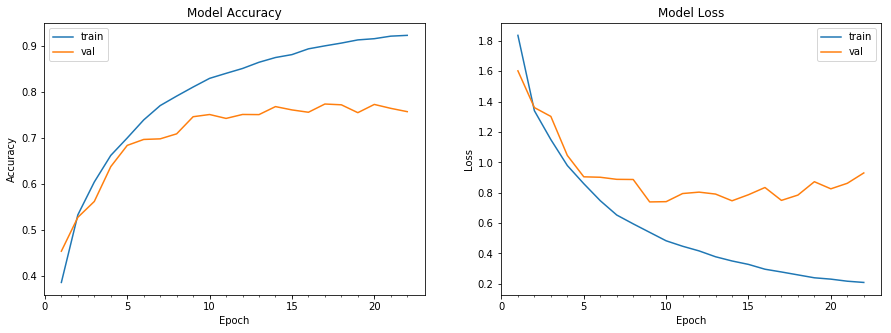

Accuracy on test data is: 75.76


In [0]:
from keras.preprocessing.image import ImageDataGenerator

# applying transformation to image
train_gen = ImageDataGenerator(zoom_range=0.0, horizontal_flip=False, featurewise_center=True, featurewise_std_normalization=True)
test_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit the data augmentation
train_gen.fit(train_features)
test_gen.fit(test_features)

training_generator= train_gen.flow(train_features, train_labels, batch_size=512)
testing_generator= test_gen.flow(test_features, test_labels, batch_size=512, shuffle=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(training_generator, 
                    steps_per_epoch = len(training_generator),
                    epochs=100,
                    validation_data = testing_generator,
                    validation_steps = len(testing_generator),
                    callbacks = callbacks_list)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy_iterator(testing_generator, model))